In the previous article, we talked about applications of Quantum in Finance and saw how it's useful in Portolio Optimization.
In this article, we will introduce the financial instruments called options. We are going to introduce the prevailing quantum approach in pricing `European Options`.

## 1. Qiskit Finance

Let's have an short overview of what Qiskit Finance is, and what sub-modules it contains

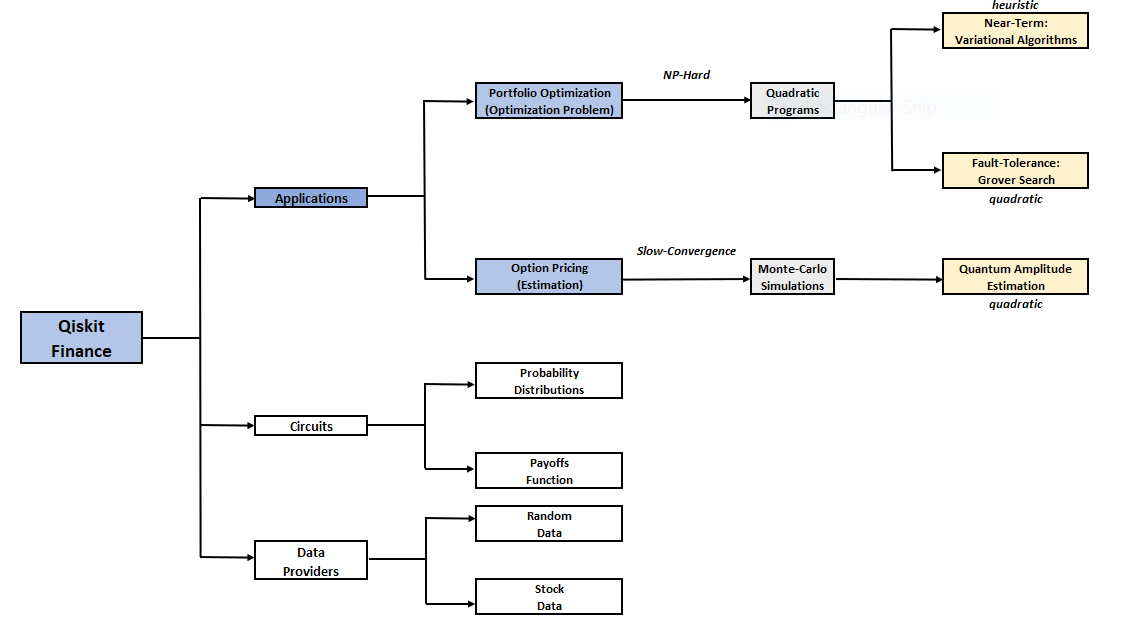

Two branches of applications that we can see in the above diagram:

    - Portfolio Optimization
    - Option Pricing   
It gives us the tools to solve optimization and option pricing problems like the european call option or fixed-income pricing.

It also have the sub modules containing circuits and tools to build these quantum circuits that we need to run these algorithms.

We also have some modules for data providers where we can load random data or we can even load historical stock market data to test our algorithms. Here we have extended the historical data loading module to load data from Eikon API.

#### Option Pricing Using Quantum Computers

We will start with the product Options, which gives power to buyer of option to exercise certain amount of stocks in particular time frame, which helps to reduce the risk of investment professionals. Some commonly used models to value options are Black-Scholes Model, Binomial Option Pricing , and Monte-Carlo Simulation. These theories have wide margins for error due to deriving their values from other assets.

The primary goal of option pricing theory is to calculate the probability that an option will be exercised, or be In-The-Money(ITM), at expiration.

Underlying asset price Stock Price, Exercise Price, Volatility, Interest Rate and time to expiration, which is the number of days between the calculation date and the option’s exercise date, are commonly used variables that are input into mathematical models to derive an option’s theoretical fair value & quite integral in accurately pricing an option.

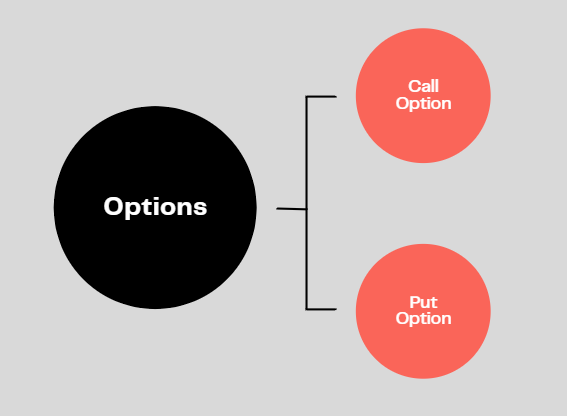

There are two type of options, Call Options, which give control to option holder to buy stocks at fixed amount(strike price) within certain time frame, whereas, Put Options, give control to option holder to sell stocks at fixed amount within certain time frame.

Being the most simplest one, we will go for European Options first, which can be excersied at the time of maturity date only and was modeled and analytically calculated by the Black-Scholes model that assumes stock prices follow a Log Normal Distribution because asset prices cannot be negative.

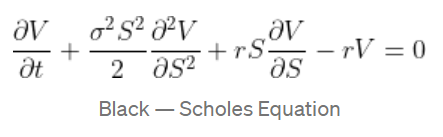


Other assumptions made by the model are that there are no transaction costs or taxes, that the risk-free interest rate is constant for all maturities, that short selling of securities with use of proceeds is permitted, and that there are no arbitrage opportunities without risk. Some of these assumptions do not hold true all of the time. It was also Calculated by Monte Carlo Techniques.

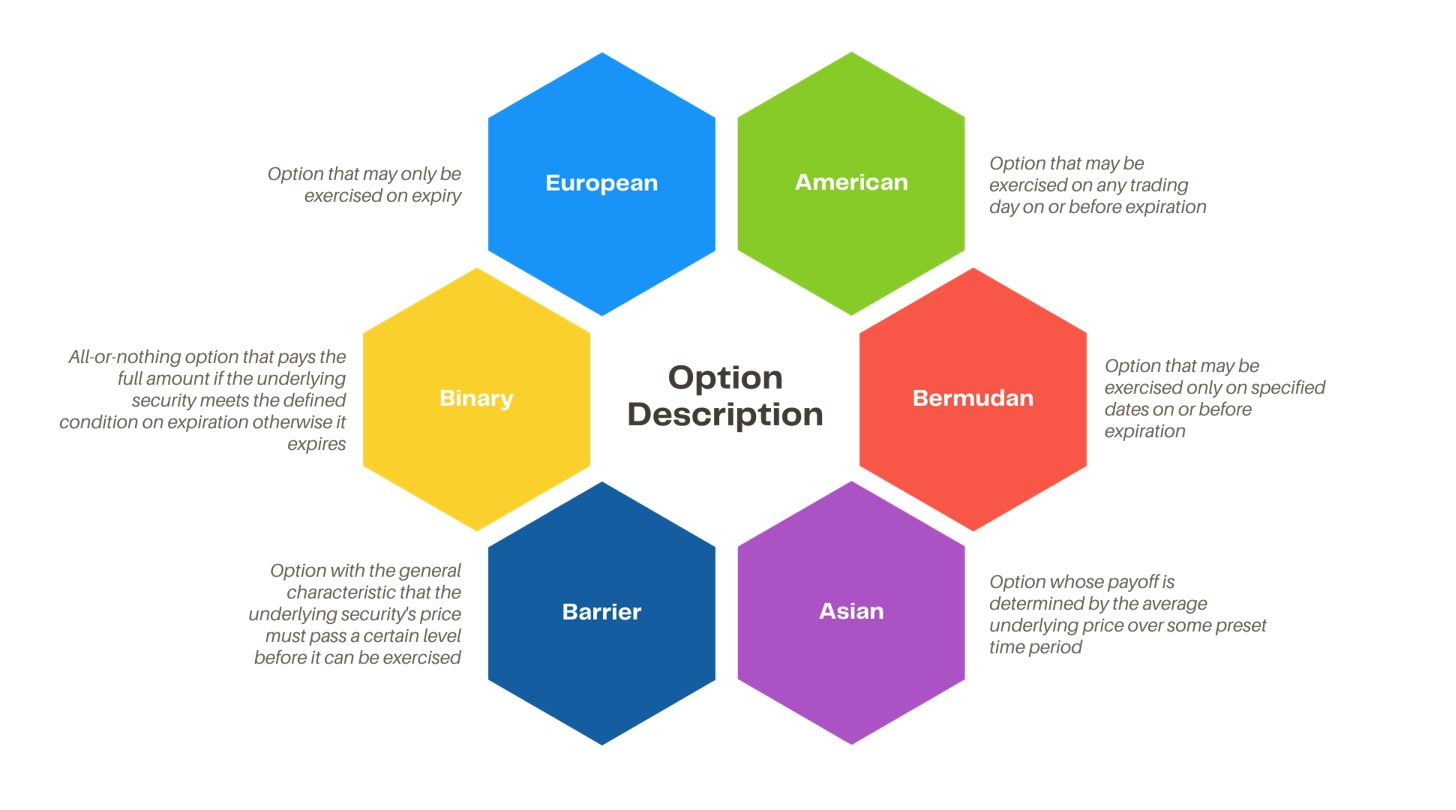

We are going to focus our attention on the most common type of option: European Options. These options are called ‘vanilla’ and are the most fundamental types of an option contract. Majority of the exotic options present some alteration to them. Time evolution of a financial instrument can be modeled using a Wiener process called Geometric Brownian motion.

So, as now we have some introduction to a financial derivative lets move on to the Quantum Computing stuff, which will help us to calculate option pricing


#### Current Limitations
- Quantum Systems with lesser number of qubit available publicly
- Fault-tolerant Quantum Systems to be built for quadratic speed up
- More efficient ways to load classical data into quantum states and perform fast computations with them
- Effective quantum error rate of the hardware should be very small, in order to ensure that no errors occur in the applications, however  quantum error correction algorithm can be used to lower this

# 2. Environment Setup & Package Installation

Assuming you already have anaconda installed or python supported IDE To execute below codes, we need to install following modules:<br>

### Qiskit Setup & Installation
<b>Qiskit</b>: An open-source SDK for working with quantum computers at the level of circuits, algorithms, and application modules. For more info, visit [here](https://qiskit.org/)<br>

<b> Qiskit Finance</b>: It contains uncertainty components for stock/securities problems, Ising translators for portfolio optimizations and data providers to source real or random data to finance experiments. For more info, visit [here](https://github.com/Qiskit/qiskit-finance)<br>

Execute the below cells to install Qiskit and it's components:

In [112]:
# ! pip install qiskit qiskit-finance==0.2.1

Check version of Qiskit and it's installed components

In [113]:
import warnings
warnings.filterwarnings("ignore")
import qiskit.tools.jupyter
%qiskit_version_table

#### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first. You can get your api token from [here](https://quantum-computing.ibm.com/)

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

In [182]:
from qiskit import IBMQ
IBMQ.save_account('MY_API_TOKEN', overwrite=True)

### Eikon API Installation
<b>Eikon API</b>: It allows to access data directly from Eikon or Refinitv Workspace using python giving capabilities to data scientists, quants to prototype or productionize solutions.For more info, visit [here](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api)

Execute the below cells to install Eikon:

In [115]:
# ! pip install eikon

Check version of Eikon API

In [116]:
import eikon as ek
print("Eikon version: ", ek.__version__)

Eikon version:  1.1.12


#### Setup Eikon API
I have saved my Eikon Data API key in a file for security reason and not displaying here in notebook.

In [117]:
eikon_key = open("eikon.txt","r")
ek.set_app_key(str(eikon_key.read()))
eikon_key.close()

##### Other packages which needs to be installed if not installed already- <b>numpy</b>, <b>pandas</b>, <b>matplotlib</b>, <b>seaborn</b>

### Importing Packages

In [118]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import qiskit
from qiskit import Aer, QuantumCircuit
from qiskit_finance.data_providers._base_data_provider import BaseDataProvider
from qiskit.finance.applications.ising import portfolio
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA

## 3. Getting Data using Eikon API & Pre-Processing

#### Defining EikonDataProvider class for Loading Data as needed by Qiskit
We will inherit BaseDataProvider from data provider module of Qiskit Finance to extend it's functionality of getting data from Eikon API in desired format and make use of existing functions.

In [119]:
class EikonDataProvider(BaseDataProvider):
    """
    The abstract base class for Eikon data_provider.
    """
    def __init__(self, stocks_list, start_date, end_date):
        '''
        stocks -> List of interested assets
        start -> start date to fetch historical data
        end -> 
        '''
        super().__init__()
        self._stocks = stocks_list
        self._start = start_date
        self._end = end_date
        self._data = []
        self.stock_data = pd.DataFrame()
        
    def run(self):
        self._data = []
        stocks_notfound = []
        stock_data = ek.get_timeseries(self._stocks,
                  start_date=self._start, 
                  end_date=self._end, 
                  interval='daily',
                  corax='adjusted')
        for ticker in self._stocks:
            stock_value = stock_data['CLOSE']
            self.stock_data[ticker] = stock_data['CLOSE']
            if stock_value.dropna().empty:
                stocks_notfound.append(ticker)
            self._data.append(stock_value)

### Initializing Required Parameters

In [120]:
# List of stocks 
stock_list = ['FB.O']

# Start Date
start_date = datetime.datetime(2020,12,1)

# End Date
end_date = datetime.datetime(2021,12,1)

# Set number of equities to the number of stocks
num_assets = len(stock_list)

# Set the risk factor
risk_factor = 0.7

# Set budget
budget = 2

# Scaling of budget penalty term will be dependant on the number of assets
penalty = num_assets

### Getting data from Eikon API using EikonDataProvider class

In [121]:
data = EikonDataProvider(stocks_list = stock_list, start_date=start_date, end_date=end_date)
data.run()

In [122]:
# Top 5 rows of data 
df = data.stock_data
df.head()

,FB.O
Date,
2020-12-01,286.55
2020-12-02,287.52
2020-12-03,281.85
2020-12-04,279.7
2020-12-07,285.58


In [123]:
df.describe()

,FB.O
count,253.000000
mean,316.401403
std,36.680760
min,245.640000
25%,278.010000
50%,324.630000
75%,343.180000
max,382.180000


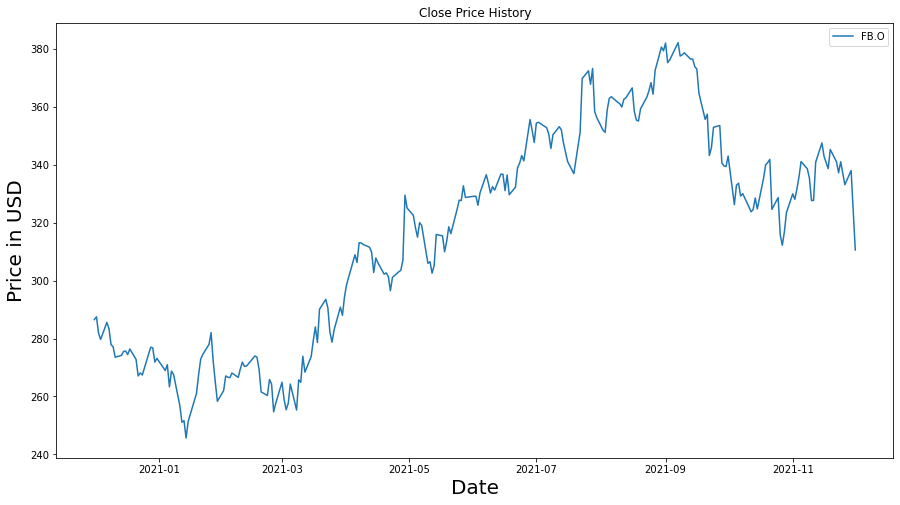

In [124]:
# Closing Price History
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df)
plt.title('Close Price History')
plt.xlabel('Date',fontsize =20)
plt.ylabel('Price in USD',fontsize = 20)
ax.legend(df.columns.values)
plt.show()

For the purposes of this article we are going to direct our attention towards the Qiskit Finance application module by IBM, more specifically we are going to look at the quantum computing approach for pricing European Call options. In the Qiskit tutorial we can look at the gradual construction of a circuit specific for European Call.

In [125]:
df.tail()

,FB.O
Date,
2021-11-24,341.06
2021-11-26,333.12
2021-11-29,338.03
2021-11-30,324.46
2021-12-01,310.6


In [126]:
strike_price = 315   # agreed upon strike price
T = 40 / 253         # 40 days to maturity

S = 310.6              # initial spot price
# vol = 0.4            # volatility of 40%
vol = df['FB.O'].pct_change().std()
r = 0.05             # annual interest rate of 4%

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

In [127]:
low

306.2211877059792

In [128]:
high

319.90894524815974

In [129]:
import numpy as np
from qiskit.algorithms import AmplitudeEstimation
from qiskit_finance.circuit.library import EuropeanCallPricingObjective  # F
from qiskit.circuit.library import LogNormalDistribution, NormalDistribution
from qiskit_finance.applications import EuropeanCallPricing
from qiskit_finance.applications.estimation import EuropeanCallDelta
from qiskit import Aer
from qiskit.algorithms import IterativeAmplitudeEstimation
sim = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)

# number of qubits to represent the uncertainty
num_uncertainty_qubits = 5

## 4. Log Normal Distribution
A random variable `X` is said to have a lognormal distribution if its natural `log (ln X)` is normally distributed. In case of stock, we assume that the variable `X` represents the continuously compounded return on the stock from time 0 to time T.

Important characteristics of the lognormal distribution are as follows:

- It has a lower bound of zero, i.e., a lognormal variable cannot take on negative values;
- The distribution is skewed to the right, i.e., it has a long right tail; and
- If given two variables that follow the lognormal distribution, the product of the variables is also log-normally distributed.

Lognormal model for stock prices is given by:

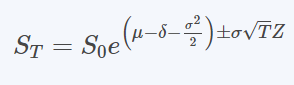

where, 

μ = expected return on stock per year

σ = volatility of the stock price per year

T = time in years

δ = dividend yield (of a dividend paying stock)

S<sub>T</sub> = stock price at time T

S<sub>0</sub> = stock price at time 0

### 4.1 Call Option

In [130]:
distribution = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

In [131]:
european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,  # approximation constant for payoff function
                                            bounds=(low, high),
                                            uncertainty_model=distribution)

In [132]:
problem = european_call_pricing.to_estimation_problem()

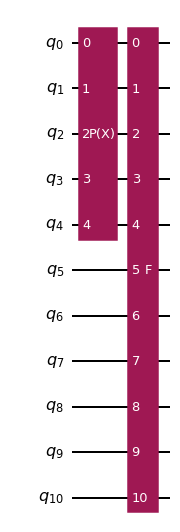

In [133]:
problem.state_preparation.draw('mpl', style='iqx')
plt.show()

In this diagram, we see implementation of the `Log-normal Distribution` on the first layer and `Linear Amplitude Estimation` function on the second layer. In both <b>European call</b> and <b>European put</b> implementations a central algorithm is Iterative Amplitude Estimation. Crucially, this implementation does not rely on `Quantum Phase Estimation`, instead it bases only on select Grover iterations. Essentially, we are interested in the probability of measuring ∣1⟩ in the last qubit.

In [134]:
epsilon = 0.01  # determines final accuracy
alpha = 0.05  # determines how certain we are of the result

ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

In [135]:
result = ae.estimate(problem)

In [136]:
conf_int_result = np.array(result.confidence_interval_processed)
print("Esimated value: \t%.4f" % european_call_pricing.interpret(result))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int_result))

Esimated value: 	0.3025
Confidence interval: 	[0.2465, 0.3586]


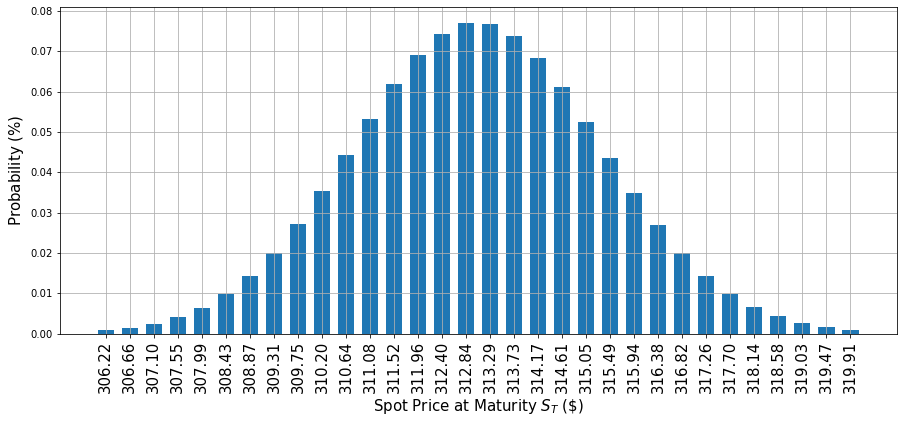

In [137]:
x = distribution.values
y = distribution.probabilities
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.3)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=10)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

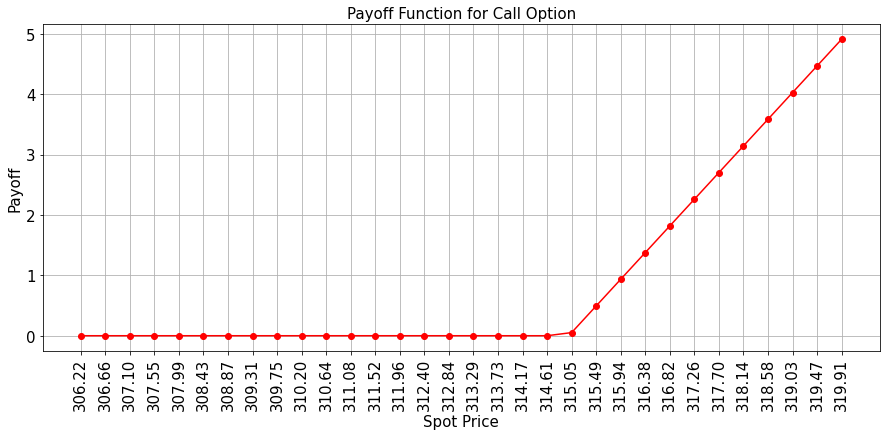

In [166]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = distribution.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize=(15,6))
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function for Call Option", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [139]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(distribution.probabilities, y)
exact_delta = sum(distribution.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.2472
exact delta value:   	0.2180


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff. Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases. However, since we are only interested in the probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

In [140]:
european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=distribution,
)

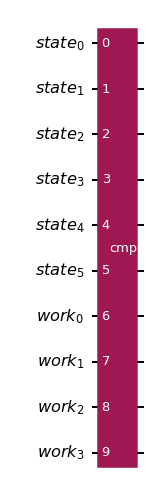

In [141]:
european_call_delta._objective.decompose().draw('mpl', style='iqx')
plt.show()

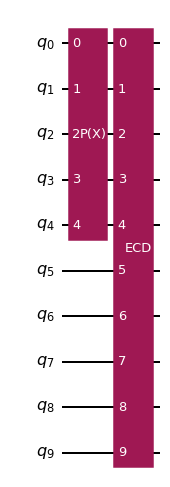

In [142]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(distribution, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw('mpl', style='iqx')
plt.show()

In [143]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

In [144]:
result_delta = ae_delta.estimate(problem)

In [145]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.2180
Esimated value: 	0.2165
Confidence interval: 	[0.2133, 0.2197]


### 4.2 Put Option

In [151]:
put_distribution = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

In [153]:
put_european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,  # approximation constant for payoff function
                                            bounds=(low, high),
                                            uncertainty_model=put_distribution)

In [154]:
put_problem = put_european_call_pricing.to_estimation_problem()

In [156]:
epsilon = 0.01  # determines final accuracy
alpha = 0.05  # determines how certain we are of the result

ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

In [159]:
put_result = ae.estimate(put_problem)

In [160]:
put_conf_int_result = np.array(put_result.confidence_interval_processed)
print("Esimated value: \t%.4f" % european_call_pricing.interpret(put_result))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(put_conf_int_result))

Esimated value: 	0.3386
Confidence interval: 	[0.2925, 0.3847]


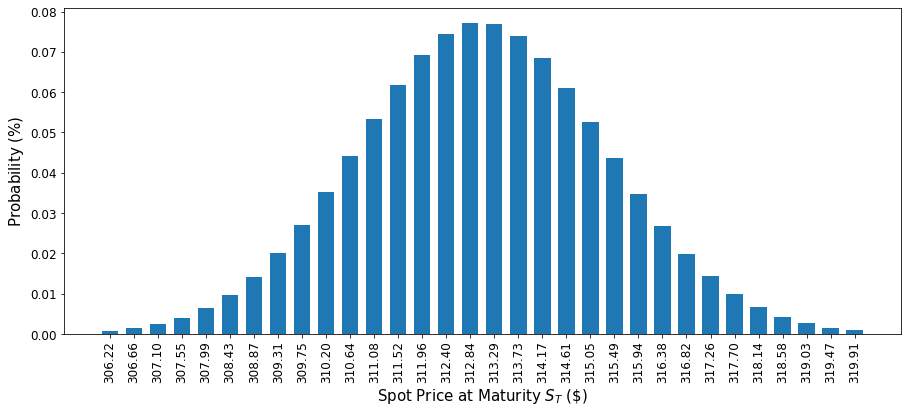

In [162]:
x = put_distribution.values
y = put_distribution.probabilities
plt.figure(figsize=(15,6))
plt.bar(x, y, width=0.3)
plt.xticks(x, size=12, rotation=90)
plt.yticks(size=12)
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

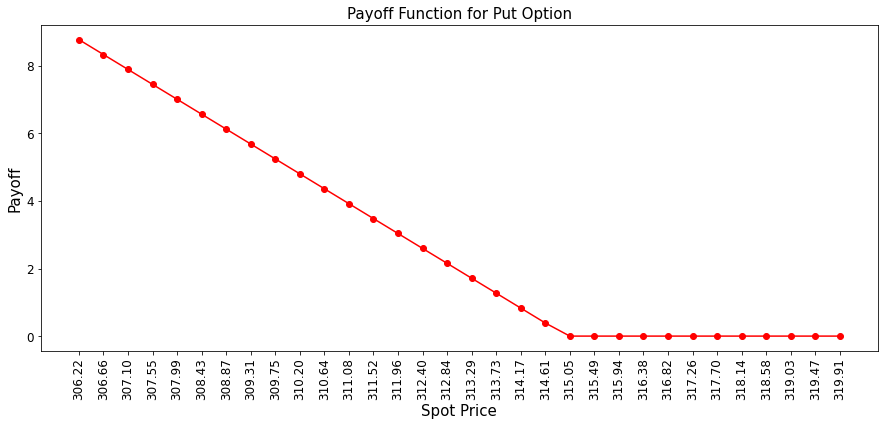

In [165]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = distribution.values
y = np.maximum(0, strike_price-x)
plt.figure(figsize=(15,6))
plt.plot(x, y, "ro-")
plt.title("Payoff Function for Put Option", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=12, rotation=90)
plt.yticks(size=12)
plt.show()

In [181]:
# evaluate exact expected value (normalized to the [0, 1] interval)
put_exact_value = np.dot(put_distribution.probabilities, y)
conf_int = np.array(put_result.confidence_interval_processed)
print("Exact Expected Value:\t%.4f" % exact_value)
print("Esimated value: \t%.4f" % european_call_delta.interpret(put_result))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact Expected Value:	0.2472
Esimated value: 	0.3386
Confidence interval: 	[0.2925, 0.3847]


## 5. Leveraging Qiskit Runtime
Due to limitation in number of publicly available qubits of IBMQ systems, we will be using 2 qubits to test it on real quantum computer. You can find another notebook `Option Pricing using Qiskit and Eikon Data API (Qiskit Runtime).ipynb` for this.

## 6. Conclusion
We saw how to account for some of the more complex features present in european call options such as path-dependency with barriers and averages. 

Future work may involve calculating the price derivatives with a quantum computer. Pricing options relies on Amplitude Estimation. This quantum algorithm allows a quadratic speed-up compared to traditional Monte Carlo simulations, but will most likely require a universal faulttolerant quantum computer.

Quantum computers are expected to have substantial impact on the Finance industry, as they will eventually be able to solve certain problems considerably faster than the best known classical algorithms.

Currently, it is a major challenge to determine when this impact will occur for each application, and, in fact, one of the most pressing challenges is to redesign quantum algorithms in order to both considerably reduce the quantum hardware requirements and at the same time keep their provable impact.

I hope this article gives a good start in the exploration of the wonderful field of research on option pricing. Advances in quantum algorithms together with better quantum hardware will continue to bring these applications closer to reality.

## 7. References:
- https://qiskit.org/documentation/tutorials/finance/03_european_call_option_pricing.html
- Option Pricing using Quantum Computers. Daniel J. Egger, Yue Sun, N.Stamatopoulos , C. Zoufal , R.Iten, Ning Shen, Stefan Woerner
- Quantuam Risk Analysis. Stefan Woerner , Daniel J. Egger
- Quantum Amplitude Amplification and Estimation. Gilles Brassard, Peter Høyer, Michele Mosca , Alan Tapp